# LeNet

LeNet-5는 1998년에 개발된 초기 CNN 모델중 하나이다.
2개의 합성곱과 3개의 완전 연결 계층을 나타낸다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

import torchvision
import torchvision.transforms as transforms # 데이터 custum

import numpy as np
import matplotlib.pyplot as plt

### 모델 생성

In [2]:
## 모델의 생성
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, out_channels=6, kernel_size=5) # 28x28x6
        # self.av1 = nn.AvgPool2d(2) # 14x14x6 --> 해당 아키텍쳐는 avg pool 을 사용하였으나 max pool 사용
        self.conv2 = nn.Conv2d(6, 16, 5) # 10x10x16
        # self.av2 = nn.AvgPool2d(2) # 5x5x16

        ## FC
        self.fc1 = nn.Linear(5*5*16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = self.av1(x)
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        # x = self.av2(x)
        x = F.max_pool2d(x, (2, 2))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
lenet = LeNet()
print(lenet)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [9]:
# 모델 학습

def train(net, trainloader, optim, epoch): # 모델, traindata, 최적화모듈, epoch
    loss_total = 0.0
    for idx, data in enumerate(trainloader):
        net.train() # model 을 train mode로 만듦
        ip, label = data
        optim.zero_grad()
        op = net(ip) # 예측값
        loss = nn.CrossEntropyLoss() (op, label)  # 실제 값과 예측값의 loss
        optim.step()

        loss_total += loss.item() # loss의 출력값만

        if (idx+1)%1000==0:
            print(
                f'Epoch number {epoch+1}, Mini Batches : {idx+1 }, epochloss = {loss_total/1000}'
            ) # 이때 1000은 에폭마다 계산되는 데이터의 개수

            loss_total= 0.0 # 1000번마다 손실 초기화

In [4]:
# test
def test(net, testloader):
    success = 0 # 정답
    counter = 0 # 전체 개수
    net.eval()
    with torch.no_grad(): # 학습하지 않음
        for data in testloader:
            im, label = data
            op = net(im) # output의 결과는 softmax에 의해 확률값으로 나오게 된다.
            _, pred = torch.max(op.data, 1) # 1번째 차원의 최댓값 인덱스를 찾는다
            counter += label.size(0) # 배치사이즈의 개수를 더한다
            success += (pred == label).sum().item() # 정답의 개수를 구한다.
    print(
        'LeNet accuracy on 10000 images from test dataset : %d %%' %(100 * success/counter)
    )

### 데이터 로드

In [5]:
# 데이터 불러오기

# transforms compose 를 사용하여 데이터를 불러옷면서 정규화, resize, crop 등을 진행할 수 있다.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(), # data augmentation
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 3개 채널에 대해서 (평균), (분산)
    ]
)
# data augmentation은 훈련에만 필요하므로 제거

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 3개 채널에 대해서 (평균), (분산)
    ]
)

## train 데이터

# torchvision 의 dataset을 사용하여 transform을 적용하고, train data 여부를 결정
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=train_transform, download=True
)

# dataloader를 이용하여 batchsize를 결정, shffle 여부 등의 결정을 한다.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=1)


## test data

testset = torchvision.datasets.CIFAR10(
        root = './data', train=False, transform = test_transform, download=True
)

testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True, num_workers = 1) # 배치는 전체 사이즈


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 95513065.14it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
def imageshow(img):
    img = img/2 + 0.5 # 이미지 비정규화
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # tensor와 Numpydml 차이 (channels, w, h) , (w, h, chnnels)
    plt.show()

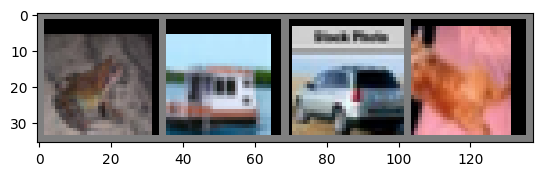

In [7]:
td = iter(trainloader) # 배치 1개 만큼의 데이터 로드
imgs, labels = next(td) #

imageshow(torchvision.utils.make_grid(imgs[:4]))


### 훈련

In [10]:
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

for epoch in range(50):
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()
print('finishing')

Epoch number 1, Mini Batches : 1000, epochloss = 2.3065745244026186
Epoch number 1, Mini Batches : 2000, epochloss = 2.3060865783691407
Epoch number 1, Mini Batches : 3000, epochloss = 2.306880190610886
Epoch number 1, Mini Batches : 4000, epochloss = 2.3072589244842527
Epoch number 1, Mini Batches : 5000, epochloss = 2.3076819844245913
Epoch number 1, Mini Batches : 6000, epochloss = 2.308178396463394

LeNet accuracy on 10000 images from test dataset : 10 %

Epoch number 2, Mini Batches : 1000, epochloss = 2.305973835468292
Epoch number 2, Mini Batches : 2000, epochloss = 2.307221682071686
Epoch number 2, Mini Batches : 3000, epochloss = 2.3079449746608733
Epoch number 2, Mini Batches : 4000, epochloss = 2.3087687640190127
Epoch number 2, Mini Batches : 5000, epochloss = 2.3065822129249574
Epoch number 2, Mini Batches : 6000, epochloss = 2.305477823972702

LeNet accuracy on 10000 images from test dataset : 10 %

Epoch number 3, Mini Batches : 1000, epochloss = 2.3081484220027924
Epoch

In [44]:
model_path = './cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

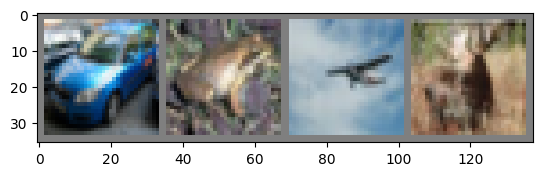

In [50]:
d_iter = iter(testloader)
im, gT = next(d_iter)

imageshow(torchvision.utils.make_grid(im[:4]))

In [52]:
lenet = LeNet()
lenet.load_state_dict(torch.load(model_path))
op = lenet(im)

_, pred = torch.max(op, 1)
print([classes[pred[j]] for j in range(4)])

['deer', 'horse', 'horse', 'horse']


In [48]:
labels.size(0)

8

In [55]:

## accuracy 구현하기

success = 0
counter = 0

# test.eva
with torch.no_grad():
    for data in testloader:
        ip, labels = data
        op = lenet(ip)
        _, pred = torch.max(op.data, 1)
        counter += labels.size(0)
        success += (pred == labels).sum().item()

print(100*success/counter)

9.35


In [ ]:
successL = [0. for _ in range(10)]
counterL = [0. for _ in range(10)]

lenet.eval()
with torch.no_grad():
    for data in testloader:
        im, gT = data
        op = lenet(im)
        _, pred = torch.max(op, 1) # 예측값에 대해서 가장 높은 확률을 가진 index를 추가
        c = (pred == gT).squeeze() # 실제값과 예측값의 일치 여부를 나타내는 boolean 배열
        for i in range(10000):
            gT_curr = gT[i]
            successL[gT_curr] += c[i].item()
            counterL[gT_curr] += 1
for i in range(10):
    print( classes[i], 100 * successL[i]/counterL[i])
